<a href="https://colab.research.google.com/github/iremcetin/Attention_generation/blob/main/SYN_Emidec_all_expVAE_v9%5Bmyo_only%5D_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Proposed approach (1-channel)**
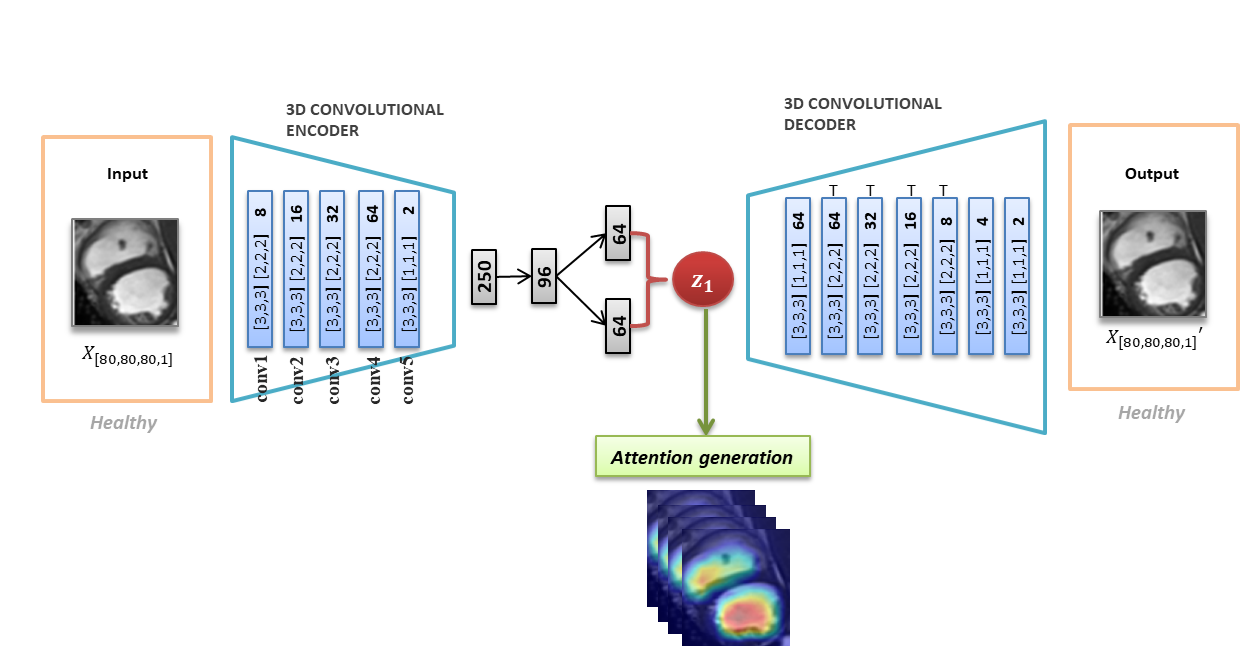

# **Imports**


In [ ]:
!pip install -q monai
!pip install tqdm
!pip install nibabel
!pip install scikit-learn
!pip install pyradiomics

     |████████████████████████████████| 501kB 8.7MB/s 
     |████████████████████████████████| 194kB 8.4MB/s 
     |████████████████████████████████| 47.4MB 64kB/s 
     |████████████████████████████████| 102kB 12.0MB/s 
     |████████████████████████████████| 552kB 46.0MB/s 


In [ ]:
# Imports for Radiomics
import SimpleITK as sitk
import six
import nibabel as nib
import radiomics

In [ ]:
# Imports #2
import os
import cv2
import glob
import random
import numpy as np
import os.path
import errno
import codecs
import shutil
import pandas as pd


import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import tempfile
from PIL import Image
#from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from __future__ import print_function
from collections import OrderedDict, Counter
from functools import reduce
from operator import mul

from sklearn.model_selection import train_test_split


In [ ]:
# import pytorch
import torch
from torch.utils.tensorboard import SummaryWriter
from torch.nn import functional as F
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid

In [ ]:
# import monai - for the image transformations
import monai
#from monai.networks.utils import eval_mode
from monai.transforms import (
    AddChannel, Compose, LoadImage, RandRotate90, 
    Resize, ScaleIntensityRange, ToTensor, NormalizeIntensity,
    RandFlip, RandSpatialCrop, ResizeWithPadOrCrop, ThresholdIntensity, ScaleIntensity
)
from monai.metrics import compute_roc_auc
monai.config.print_config()
random_seed = 42
monai.utils.set_determinism(random_seed)
np.random.seed(random_seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MONAI version: 0.5.2
Numpy version: 1.19.5
Pytorch version: 1.8.1+cu101
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: feb3a334b7bbf302b13a6da80e0b022a4cf75a4e

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.16.2
Pillow version: 7.1.2
Tensorboard version: 2.5.0
gdown version: 3.6.4
TorchVision version: 0.9.1+cu101
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.41.1
lmdb version: 0.99
psutil version: 5.4.8

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



# **Necessary functions (Definitions)**

In [ ]:
def nii_reader(path):
    reader = sitk.ImageFileReader()
    reader.SetImageIO("NiftiImageIO")
    reader.SetFileName(path)
    img = reader.Execute();
    return img

In [ ]:
def mask_operations(mask, patient_id, path_binmask, low_thresh = 0, up_thresh = 0, Train = True):
    ##### Note : Mask is not binarize --> You need to binarize it
    ##### Step 1 : Binary threshold 
#    mask_array = sitk.GetArrayFromImage(mask)
    if Train==True:
      inside_val = 0
      outside_val = 1
    else:
      inside_val = 1
      outside_val = 0
    btif=sitk.BinaryThresholdImageFilter()
    btif.SetLowerThreshold(low_thresh) # lower value to set as background = 0 : Inside value
    btif.SetUpperThreshold(up_thresh) # upper value, if you set 2: label 3 will be visible, if you set 1, label 2 and 3 visible 
    btif.SetInsideValue(inside_val)
    btif.SetOutsideValue(outside_val)
    mask = btif.Execute(mask)
    ##### Step 2 : Morphological closing --> fill the pixels with 0 inside ROI with 1 (fill the holes inside the ROI)
    closing = sitk.BinaryMorphologicalClosingImageFilter()
    mask =closing.Execute(mask)
#    binMask = sitk.GetArrayFromImage(mask) ### To check the mask's pixel values
    
    ### save image to check later
    binmask_path = path_binmask + patient_id + '_binMask.nii.gz'
    sitk.WriteImage(mask, binmask_path)
    
    
    return mask

In [ ]:
def find_max_dim(shape_img, shape_gt):
    res1 = max(shape_img, key = lambda i : i[0])[0]
    res2 = max(shape_img, key = lambda i : i[1])[1]
    res3 = max(shape_img, key = lambda i : i[2])[2]
    print("Maximum image dimensions, dim1: %d, dim2: %d, dim3: %d"%(res1, res2, res3))
    res4 = max(shape_gt, key = lambda i : i[0])[0]
    res5 = max(shape_gt, key = lambda i : i[1])[1]
    res6 = max(shape_gt, key = lambda i : i[2])[2]
    print("Maximum GT dimensions, dim1: %d, dim2: %d, dim3: %d"%(res4, res5, res6)) # These dimensions must be the same as image patches (res1, res2 and res3)

    return

In [ ]:
def create_patches(path, patient,  cohort_name, Train):
    low_threshold = 0
    up_threshold = 1
    # Define the image paths [images and masks]
    if cohort_name == "SYN":
        
        img_path = os.path.join(path,"%s.nii.gz" %(patient)) # Directory of image nii
        gt_path =os.path.join(path, "%s_gt.nii.gz" %(patient)) # Directory of Ground truth
        binMask_path = "/content/gdrive/MyDrive/Synthetic Data/syn_python/EMIDEC_cropped/synthetic_from_emidec_binMask/"
    else: 
        img_path=os.path.join(path,"Images","%s.nii.gz" %(patient)) # Directory of image nii
        gt_path =os.path.join(path, "Contours","%s.nii.gz" %(patient)) # Directory of Ground truth
        binMask_path = "/content/gdrive/MyDrive/EMIDEC/Emidec_DATASET/processed_emidec_dataset/myo_only/binMask/"

    print(f"Image path {img_path}")
    # Load the images with sitk
    img = nii_reader(img_path)
    gt_img = nii_reader(gt_path)

    # mask operations
    # Combine 2 labels together
   
    gt_img_l1 = mask_operations(gt_img, patient, binMask_path, low_threshold, up_threshold, Train)  # make the segmentation 1-layer only
    

    # ED
    (bbox, corrected_mask) = radiomics.imageoperations.checkMask(img, gt_img_l1, correctMask=True )
    (cropped_img, cropped_gt) = radiomics.imageoperations.cropToTumorMask(img, gt_img_l1, boundingBox=bbox)
    (cropped_gt_scar, a) = radiomics.imageoperations.cropToTumorMask(gt_img, gt_img_l1, boundingBox=bbox )
    return cropped_img, cropped_gt, cropped_gt_scar

In [ ]:
def preprocess_files(path_training, minf_cohort, cohort_name, Train = True):
    patient_ids=[] 
    Label = []
    images = []  # store the images and the segmentations for ED and ES separately - for the future experiments
    segs =[] 
    segs_scar =[]
    shape_img=[] 
    shape_gt = []

    if cohort_name =="SYN":
       save_path = "/content/gdrive/MyDrive/Synthetic Data/syn_python/EMIDEC_cropped/saved_syn_from_emidec_myo_only/"
    
    else:
      save_path = "/content/gdrive/MyDrive/EMIDEC/Emidec_DATASET/processed_emidec_dataset/myo_only/Training_cropped"
    #data = np.zeros((nb_patients,428,512,25)) # PREPROCESSING NEEDED : BOUNDARY BOX

    low_threshold = 0
    up_threshold = 1
    for j in range(len(minf_cohort)):
          if cohort_name =="SYN":
            path_files=path_training
            file_p = path_training + minf_cohort[j] + ".nii.gz"
            gt_p =  path_training + minf_cohort[j] + "_gt.nii.gz"
           
          else:
            path_files = os.path.join(path_training, minf_cohort[j] )



          patient_id = minf_cohort[j]
          print('%s with %s'%(patient_id, cohort_name))  
          
         

          
          [cropped_img, cropped_gt, cropped_gt_scar] = create_patches(path_files, patient_id, cohort_name, Train)

          # ED
          cropped_arr =  sitk.GetArrayFromImage(cropped_img)
          cropped_gt_arr = sitk.GetArrayFromImage(cropped_gt)

          #################################################################################################
          # multiply mask and ground truth to remove LV blood pool from the image = only for EMIDEC dataset
          multiply = sitk.MultiplyImageFilter()
          cropped_gt_casted = sitk.Cast(cropped_gt, sitk.sitkFloat64)
          
          new_img = multiply.Execute(cropped_img, cropped_gt_casted)
          
          new_img_arr = sitk.GetArrayFromImage(new_img)
          cropped_img = new_img
          #################################################################################################

          # Multiply scar segmentation with 1-label segmentation = Removes LV Blood pool from the segmentation 
          # This part is for visualization purposes
          

          filename_img = os.path.join(save_path,"%s.nii.gz" %(patient_id))
          print(f"saved in {filename_img}")
          filename_gt = os.path.join(save_path,"%s_gt.nii.gz" %(patient_id))
          #filename_img_org = os.path.join(save_path,"%s_org.nii.gz" %(patient_id))
          filename_gt_scar = os.path.join(save_path,"%s_gt_scar.nii.gz" %(patient_id))
          images.append(filename_img)
          segs.append(filename_gt)
          #segs_scar.append(filename_gt_scar)

          sitk.WriteImage(cropped_img, filename_img)
          #sitk.WriteImage(cropped_img, filename_img_org)
          sitk.WriteImage(cropped_gt, filename_gt)

          sitk.WriteImage(cropped_gt_scar, filename_gt_scar)
          #shape_img.append(cropped_arr.shape)
          shape_img.append(cropped_arr.shape)
          shape_gt.append(cropped_gt_arr.shape)

          if cohort_name =="MINF":
                    value = 1
          else: 
                value = 0
          
          Label.append(value)
          patient_ids.append(patient_id)


    return images, segs, Label, shape_img, shape_gt

In [ ]:
# read the files
# load the variables
# If the files already cropped, you only need to load the images.

def load_preprocessed_files(path_training, minf_cohort, cohort_name):
    patient_ids=[] 
    Label = []
    images = []  # store the images and the segmentations for ED and ES separately - for the future experiments
    segs =[] 
    segs_scar =[]
    shape_img=[] 
    shape_gt = []

    if cohort_name =="SYN":
      save_path = path_training
    
    else:
      save_path = "/content/gdrive/MyDrive/EMIDEC/Emidec_DATASET/processed_emidec_dataset/myo_only/Training_cropped"
    #data = np.zeros((nb_patients,428,512,25)) # PREPROCESSING NEEDED : BOUNDARY BOX


    for j in range(len(minf_cohort)):
          path_files = os.path.join(path_training, minf_cohort[j] )
          patient_id = minf_cohort[j]
 
          print('%s with %s'%(patient_id, cohort_name))  

          if cohort_name =="SYN":
            filename_img_path = os.path.join(save_path,"%s" %(patient_id))
            filename_gt_path = os.path.join(save_path,"%s" %(patient_id))
            #filename_img_org = os.path.join(save_path,"%s_org.nii.gz" %(patient_id))
            filename_gt_scar_path = filename_gt_path

          else:

            filename_img_path = os.path.join(save_path,"%s.nii.gz" %(patient_id))
            filename_gt_path = os.path.join(save_path,"%s_gt.nii.gz" %(patient_id))
            #filename_img_org = os.path.join(save_path,"%s_org.nii.gz" %(patient_id))
            filename_gt_scar_path = os.path.join(save_path,"%s_gt_scar.nii.gz" %(patient_id))
            
          images.append(filename_img_path)
          segs.append(filename_gt_path)
          segs_scar.append(filename_gt_scar_path)

          filename_img = nii_reader(filename_img_path)
          filename_gt = nii_reader(filename_gt_path)
          filename_scar = nii_reader(filename_gt_scar_path)
      
          
          filename_img_arr = sitk.GetArrayFromImage(filename_img)
          gt_shape = sitk.GetArrayFromImage(filename_gt)
          scar_shape = sitk.GetArrayFromImage(filename_scar)

          shape_img.append(filename_img_arr.shape)
          shape_gt.append(gt_shape.shape)
          ####################################
          if cohort_name =="MINF":
                    value = 1
          else: 
                value = 0
          
          Label.append(value)
          patient_ids.append(patient_id)


    return images, segs, Label, shape_img, shape_gt

In [ ]:
emidec_columns = ["GBS", "SEX", "AGE", "TOBACCO", "OVERWEIGHT", "ART_HYPERT", "DIABETES", "FHCAD", "ECG", "TROPONIN", "KILLIP", "FEVG", "NTProNBP"]


def load_clinical_info(path, info_files, emidec_columns, folders):
    clinical_info = pd.DataFrame(index=folders, columns=emidec_columns)
    for i in range(len(info_files)):

        Info_path=os.path.join(path,info_files[i])

        with open(Info_path, 'r', encoding='mac_roman') as Info : 
             line = Info.readlines()
             for j in range(2, len(emidec_columns)+2):   
                 if j == 2:
                    clinical_info.iloc[i,j-2] = line[j].rstrip().split(":")[1][:3]
                 else:
                    clinical_info.iloc[i,j-2] = line[j].rstrip().split(":")[1]   


    return clinical_info
                


In [ ]:
# Overlay Original image and GradCAM heatmap
def superimposed_image_def(cam_img, original_img, alpha = 0.6):
    original_img = original_img[0, 0,:,:] # If you use different image check here and change
    cam_img = cam_img[0,0,:,:] # Same above
    # Make 1-channel image to 3-channel : To overlay this image with the heatmap (JET colormap = 3-channels)
    original_img = cv2.merge((original_img, original_img, original_img))
    cam_img = (cam_img - cam_img.min()) / (
               cam_img.max() - cam_img.min()
    ) *255
    
    # Convert to Heatmap ---- JET COLORMAP
    #cam_img = cam_img.astype(np.uint8)
    cam_img = cv2.applyColorMap(np.uint8(cam_img), cv2.COLORMAP_JET)

    original_img = np.uint8(
        (original_img - original_img.min())
        / (original_img.max() - original_img.min())
        * 255
    )

###### Superimpose Heatmap on Image Data #####################################
   
    superimposed_image = cv2.addWeighted(original_img, alpha, cam_img, (1-alpha), 0.0)

    return superimposed_image, cam_img, original_img

# **User defined variables (Configs)**

In [ ]:
IMG = 1 # 1 channel input 

In [ ]:
#Note: Check the batch size - CHANGE?! & num_workers =?
batch_size = 1
num_workers = 1
seed = 1
epochs = 200

In [ ]:
win_size = (80, 80, 80)  # Dimensions of the input  

In [ ]:
HDIM =  96 # LVAE + MLP = h_dims = [96, 48, 24] # dim of the FC layer before the latent space (mu and sigma)
latent_size = 64
unflatten_channel = 2 # number of channels before unflatten : if IMG ==2 then 2, if IMG ==1 then 1
dim_start_up_decoder = [5,5,5] # in unflatten (inside the decoder), the dimensions will be [1, unflatten_channel, dim_startup_decoder]

n_filters_ENC = (8, 16, 32, 64, 2)
n_filters_DEC = (64, 32, 16, 8, 4, 2)

# **Load the Emidec dataset (from gdrive)**

In [ ]:
doyouhavecroppedfiles = False # if you already cropped/preprocessed files set this True o.w.
num_class = 2 # enter the number of classes in the dataset 

In [ ]:

# Give permission to google drive 
# Generated files will be saved there

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
training_path = "/content/gdrive/MyDrive/EMIDEC/Emidec_DATASET/Training"  

In [ ]:
path_files = os.listdir(training_path)
import glob
info_files = [f for f in os.listdir(training_path) if f.endswith('.txt')] # these are info files
info_files.sort()
folders =  [f for f in os.listdir(training_path) if not f.endswith('.txt')]# the others are the patient folders
folders.sort()

In [ ]:
clinical_info_training = load_clinical_info(training_path, info_files, emidec_columns, folders)

In [ ]:
clinical_info_training.iloc[33:]

,GBS,SEX,AGE,TOBACCO,OVERWEIGHT,ART_HYPERT,DIABETES,FHCAD,ECG,TROPONIN,KILLIP,FEVG,NTProNBP
Case_P001,10,M,32,1,N,N,N,N,Y,130,1,35,447
Case_P002,10,M,57,1,Y,N,N,N,Y,28,1,61,192
Case_P003,8,M,67,2,N,N,N,N,Y,7,1,55,54
Case_P004,13,M,68,2,Y,N,N,N,Y,45,2,40,1075
Case_P005,10,M,62,1,Y,Y,Y,Y,N,7,1,55,1024
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Case_P096,10,M,49,1,Y,Y,N,N,Y,88,1,50,15
Case_P097,10,M,41,1,Y,N,N,N,Y,380,1,50,14
Case_P098,10,M,54,3,N,N,N,N,Y,210,1,40,221
Case_P099,10,M,30,3,N,N,N,N,Y,150,2,35,329


In [ ]:
# Preprocess the values
cleanup_nums = {"SEX":     {" F": 1, " M": 0},
                "OVERWEIGHT": {" N": 0, " Y": 1},
                "ART_HYPERT": {" N": 0, "N":0, " Y": 1},
                "DIABETES": {" N": 0, " Y": 1},
                "FHCAD" : {" N": 0, " Y": 1},
                "ECG" : {" N": 0, " Y": 1}}


clinical_info_training = clinical_info_training.replace(cleanup_nums)


In [ ]:
clinical_info_training_nor = clinical_info_training[:33]
clinical_info_training_minf = clinical_info_training[33:]

In [ ]:
clinical_info_training_nor.iloc[:10]

,GBS,SEX,AGE,TOBACCO,OVERWEIGHT,ART_HYPERT,DIABETES,FHCAD,ECG,TROPONIN,KILLIP,FEVG,NTProNBP
Case_N006,10,1,70,3,0,1,0,0,1,1.1,1,60,248
Case_N012,10,0,33,3,1,0,0,0,0,2.8,1,60,89
Case_N013,10,1,40,1,0,0,0,0,0,0.35,1,60,1133
Case_N014,10,0,66,2,1,1,1,0,0,2.7,1,55,78
Case_N016,13,0,76,1,1,0,0,0,1,14,1,60,192
Case_N018,10,0,67,2,1,1,0,0,0,4.5,1,45,682
Case_N020,10,1,78,2,1,1,0,1,0,1.7,1,62,1475
Case_N023,10,1,61,2,1,0,0,0,0,0.4,1,44,3071
Case_N024,10,1,71,3,0,1,0,0,0,0.1,1,35,7598
Case_N025,10,1,67,3,1,1,1,0,0,0.5,1,60,202


# **Prepare the dataset (crop-to-segmentations)**

In [ ]:
import re
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

In [ ]:
def path_load(syn_scar_path, file_name):
      ED_img_scar = [f for f in os.listdir(syn_scar_path) if f.endswith(file_name)] # these are info files
      #ED_img_scar.sort()
      ED_img_scar = sorted_alphanumeric(ED_img_scar)
      return ED_img_scar

In [ ]:
healthy_cohort =  [param for param in folders if param.split("_")[1].startswith('N')] # the ones start with N (after _) are healthy
minf_cohort = [param for param in folders if param.split("_")[1].startswith('P')] # the ones start with P are MINF
nb_healthy =  len(healthy_cohort)
nb_minf = len(minf_cohort)

In [ ]:
print(f"There are {nb_healthy} healthy and {nb_minf} heart attack patients in the dataset.")

There are 33 healthy and 67 heart attack patients in the dataset.


In [ ]:
syn_scar_path = "/content/gdrive/MyDrive/Synthetic Data/syn_python/EMIDEC_cropped/synthetic_from_emidec/"
syn_scar_files = os.listdir(syn_scar_path)

In [ ]:
syn_scar_gt = path_load(syn_scar_path, "_gt.nii.gz")
syn_scar_img = [x for x in syn_scar_files if x not in syn_scar_gt]
syn_scar_img = sorted_alphanumeric(syn_scar_img)

In [ ]:
syn_cohort = []
for i in range(len(syn_scar_img)):
    syn_cohort.append(syn_scar_img[i][:13].split(".")[0])

In [ ]:
if doyouhavecroppedfiles == True: 
    images_minf, segs_minf, Label_minf, shape_img_minf, shape_gt_minf  = load_preprocessed_files(training_path, minf_cohort, cohort_name='MINF')
    images_nor, segs_nor, Label_nor,  shape_img_nor, shape_gt_nor  = load_preprocessed_files(training_path, healthy_cohort, cohort_name='NOR')
else:
    images_minf, segs_minf, Label_minf, shape_img_minf, shape_gt_minf = preprocess_files(training_path, minf_cohort, cohort_name='MINF', Train=True)
    images_nor, segs_nor, Label_nor, shape_img_nor, shape_gt_nor = preprocess_files(training_path, healthy_cohort, cohort_name='NOR', Train=True)


Case_P001 with MINF
Image path /content/gdrive/MyDrive/EMIDEC/Emidec_DATASET/Training/Case_P001/Images/Case_P001.nii.gz
saved in /content/gdrive/MyDrive/EMIDEC/Emidec_DATASET/processed_emidec_dataset/myo_only/Training_cropped/Case_P001.nii.gz
Case_P002 with MINF
Image path /content/gdrive/MyDrive/EMIDEC/Emidec_DATASET/Training/Case_P002/Images/Case_P002.nii.gz
saved in /content/gdrive/MyDrive/EMIDEC/Emidec_DATASET/processed_emidec_dataset/myo_only/Training_cropped/Case_P002.nii.gz
Case_P003 with MINF
Image path /content/gdrive/MyDrive/EMIDEC/Emidec_DATASET/Training/Case_P003/Images/Case_P003.nii.gz
saved in /content/gdrive/MyDrive/EMIDEC/Emidec_DATASET/processed_emidec_dataset/myo_only/Training_cropped/Case_P003.nii.gz
Case_P004 with MINF
Image path /content/gdrive/MyDrive/EMIDEC/Emidec_DATASET/Training/Case_P004/Images/Case_P004.nii.gz
saved in /content/gdrive/MyDrive/EMIDEC/Emidec_DATASET/processed_emidec_dataset/myo_only/Training_cropped/Case_P004.nii.gz
Case_P005 with MINF
Image pa

In [ ]:
images_test, segs_test, Label_test, shape_img_test, shape_gt_test  = preprocess_files(syn_scar_path, syn_cohort, cohort_name='SYN')

patient0 with SYN
Image path /content/gdrive/MyDrive/Synthetic Data/syn_python/EMIDEC_cropped/synthetic_from_emidec/patient0.nii.gz
saved in /content/gdrive/MyDrive/Synthetic Data/syn_python/EMIDEC_cropped/saved_syn_from_emidec_myo_only/patient0.nii.gz
patient1 with SYN
Image path /content/gdrive/MyDrive/Synthetic Data/syn_python/EMIDEC_cropped/synthetic_from_emidec/patient1.nii.gz
saved in /content/gdrive/MyDrive/Synthetic Data/syn_python/EMIDEC_cropped/saved_syn_from_emidec_myo_only/patient1.nii.gz
patient2 with SYN
Image path /content/gdrive/MyDrive/Synthetic Data/syn_python/EMIDEC_cropped/synthetic_from_emidec/patient2.nii.gz
saved in /content/gdrive/MyDrive/Synthetic Data/syn_python/EMIDEC_cropped/saved_syn_from_emidec_myo_only/patient2.nii.gz
patient3 with SYN
Image path /content/gdrive/MyDrive/Synthetic Data/syn_python/EMIDEC_cropped/synthetic_from_emidec/patient3.nii.gz
saved in /content/gdrive/MyDrive/Synthetic Data/syn_python/EMIDEC_cropped/saved_syn_from_emidec_myo_only/pati

# **Prepare the cases**

images_nor, Label_nor = Training
 
images_minf, Label_minf = Testing


In [ ]:
find_max_dim(shape_img_minf, shape_gt_minf)

Maximum image dimensions, dim1: 10, dim2: 61, dim3: 59
Maximum GT dimensions, dim1: 10, dim2: 61, dim3: 59


In [ ]:
find_max_dim(shape_img_nor, shape_gt_nor)

Maximum image dimensions, dim1: 9, dim2: 57, dim3: 54
Maximum GT dimensions, dim1: 9, dim2: 57, dim3: 54


In [ ]:
#indices =np.arange(clinical_info_training_nor.shape[0])
clinical_info_training[:5]

,GBS,SEX,AGE,TOBACCO,OVERWEIGHT,ART_HYPERT,DIABETES,FHCAD,ECG,TROPONIN,KILLIP,FEVG,NTProNBP
Case_N006,10,1,70,3,0,1,0,0,1,1.1,1,60,248
Case_N012,10,0,33,3,1,0,0,0,0,2.8,1,60,89
Case_N013,10,1,40,1,0,0,0,0,0,0.35,1,60,1133
Case_N014,10,0,66,2,1,1,1,0,0,2.7,1,55,78
Case_N016,13,0,76,1,1,0,0,0,1,14,1,60,192


In [ ]:
#clinical_info_train = [[np.float32(y) for y in x] for x in clinical_info_train]
#clinical_info_val = [[np.float32(y) for y in x] for x in clinical_info_val]
#### MINF: 67 and NOR: 33 ###########
### Training: 77% and Testing 33% ###
## Training: MINF: 45 NOR: 22
## Testing: MINF: 22 NOR: 11
#images_tra_ = images_nor[:22] + images_minf[:45]
#labels_tra_ = Label_nor[:22] + Label_minf[:45]
################################################
### If you have synthetic data use them as testing
images_tra_ = images_nor + images_minf
labels_tra_ = Label_nor + Label_minf
indices = np.arange(len(images_tra_))
####
#images_test = images_nor[22:] + images_minf[45:]
#labels_test = Label_nor[22:] + Label_minf[45:]
images_test = images_test ### for clarification - this is the synthetic dataset
labels_test = Label_test

# **Train and validation split**

In [ ]:
train_files, val_files, train_labels,  val_labels, indices_train, indices_val = train_test_split(images_tra_, labels_tra_, indices, test_size=0.33, random_state=42)

# **Preprocess the clinical features**

In [ ]:
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#clinical_info_train_scl = scaler.fit_transform(clinical_info_train)
#clinical_info_val_scl = scaler.transform(clinical_info_val)

In [ ]:
#type(clinical_info_train[2][2])


In [ ]:
# Testing : MINF
#clinical_info_testing_scl =scaler.transform(clinical_info_training_minf)

In [ ]:
#all_files[78]["image"]
print(f"File name -random- in training dataset: {train_files[3]}")
print(f"Label name -random- in training dataset: {train_labels[3]}")


File name -random- in training dataset: /content/gdrive/MyDrive/EMIDEC/Emidec_DATASET/processed_emidec_dataset/myo_only/Training_cropped/Case_P059.nii.gz
Label name -random- in training dataset: 1


In [ ]:
print(f"Total number of training cases: {len(train_files)}")
print(f"Total number of validation cases: {len(val_files)}")

Total number of training cases: 67
Total number of validation cases: 33


# **Transform the images before inputting to the network**

In [ ]:
# Define transforms for image
train_transforms = Compose(
    [
        LoadImage(image_only=True),
        AddChannel(),
        #ScaleIntensityRange(a_min=-1000.0, a_max=500.0, b_min=0.0, b_max=1.0, clip=True),
        #RandFlip("image", spatial_axis=0),
        #RandFlip( spatial_axis=1),
        #RandFlip( spatial_axis=2),
        #RandRotate90(prob=0.5, spatial_axes=[0, 1]),
        #NormalizeIntensity(nonzero=False, channel_wise=True),
        Resize(win_size, "trilinear", True),
        #ResizeWithPadOrCrop(spatial_size=win_size, mode="constant"),
     
        #
        ToTensor(),
    ]
)
val_transforms = Compose(
    [
        LoadImage(image_only=True),
        AddChannel(),
        #ScaleIntensityRange(a_min=-1000.0, a_max=500.0, b_min=0.0, b_max=1.0, clip=True),
        #NormalizeIntensity(nonzero=False, channel_wise=True),
        Resize(win_size, "trilinear", True),
        #ResizeWithPadOrCrop(spatial_size=win_size, mode="constant"),
        ToTensor(),
    ]
)
visualize_transforms = Compose(
    [
        LoadImage(image_only = True),
        AddChannel(),
        Resize(win_size,"trilinear"),
       
        #ResizeWithPadOrCrop(win_size),
        ThresholdIntensity(threshold=1.1),
        ToTensor(),
    ]
)

Check the images (after transformations)

In [ ]:
#Check images
case_id = 20 # enter the id of the file that you want to visualize
loader = LoadImage()
img_loaded = loader(train_files[case_id])
print(f"Case: {train_files[case_id]}")

Case: /content/gdrive/MyDrive/EMIDEC/Emidec_DATASET/processed_emidec_dataset/myo_only/Training_cropped/Case_P007.nii.gz


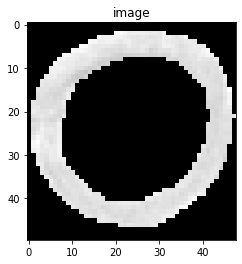

image shape: (50, 48, 7)
Cohort : 1 
Note: 0 = Healthy and 1 = MINF


In [ ]:
plt.title("image")
plt.imshow(img_loaded[0][:, :, 4], cmap="gray")
plt.show()

print(f"image shape: {img_loaded[0].shape}")
ch =train_labels[case_id]
print(f"Cohort : {ch} ")
print("Note: 0 = Healthy and 1 = MINF")
#img_loaded['image_meta_dict']

# **Define Datasets(ds) and Dataloaders [1-Channel]**

In [ ]:
class EmidecDataset(torch.utils.data.Dataset):
  def __init__(self, image_files, labels, transforms):
    self.image_files = image_files
    self.labels = labels
    self.transforms = train_transforms
    #self.clinical_info = np.asarray(clinical_info_df)
  def __len__(self):
    return len(self.image_files)

  def __getitem__(self, index):
    return self.transforms(self.image_files[index]), self.labels[index]#, self.clinical_info[index]

    #Note: to get the name of the files? -- when visualize with gradcam

In [ ]:
# Define data loaders (Training and Validation dataset)

train_ds = EmidecDataset(train_files, train_labels, train_transforms) # SCALED CLINICAL FEATURES
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)

val_ds = EmidecDataset(val_files, val_labels, val_transforms) # SCALED CLINICAL FEATURES
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, num_workers=num_workers)

In [ ]:
### Do the same for testing 
## 
test_ds = EmidecDataset(images_test, labels_test, val_transforms )
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, num_workers=num_workers)

Check the images after dataloader

File name of the selected image :  /content/gdrive/MyDrive/EMIDEC/Emidec_DATASET/processed_emidec_dataset/myo_only/Training_cropped/Case_P007.nii.gz 
Cohort name 1


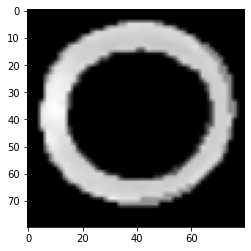

In [ ]:
#Check images after dataloader (with data transformations)
data_ex = train_ds[case_id]

#items = np.random.choice(len(train_ds), size=len(train_ds)) #*
#data = train_ds[item]  # this fetches training data with random augmentations #*
image_ex, label_ex = data_ex[0], data_ex[1]

print(f"File name of the selected image :  {train_ds.image_files[case_id]} ")
print(f"Cohort name {label_ex}")

# Detirmine the slice to be visualized
#the_slice = image_ex.shape[-1] // 2
#image_ex = image_ex.detach().cpu().numpy()
plt.imshow(image_ex[0,:,:,35], cmap="gray")

In [ ]:
seg_scar_ex = train_ds.image_files[case_id][:-7]
filename_seg_scar_ex = seg_scar_ex + "_gt_scar"+ ".nii.gz"
filename_seg_scar_ex

'/content/gdrive/MyDrive/EMIDEC/Emidec_DATASET/processed_emidec_dataset/myo_only/Training_cropped/Case_P007_gt_scar.nii.gz'

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


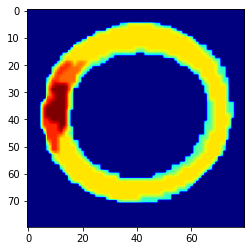

In [ ]:
seg_scar_ex_transformed = visualize_transforms(filename_seg_scar_ex)
plt.imshow(seg_scar_ex_transformed[0,:,:,35], cmap="jet")

File name of the selected image :  /content/gdrive/MyDrive/Synthetic Data/syn_python/EMIDEC_cropped/saved_syn_from_emidec_myo_only/patient21.nii.gz 
Cohort name 0


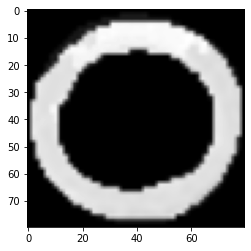

In [ ]:
#### NOW CHECK THE SYNTHETIC CASE
#Check images after dataloader (with data transformations)
data_ex = test_ds[case_id]

#items = np.random.choice(len(train_ds), size=len(train_ds)) #*
#data = train_ds[item]  # this fetches training data with random augmentations #*
image_ex, label_ex = data_ex[0], data_ex[1]

print(f"File name of the selected image :  {test_ds.image_files[case_id]} ")
print(f"Cohort name {label_ex}")

# Detirmine the slice to be visualized
#the_slice = image_ex.shape[-1] // 2
#image_ex = image_ex.detach().cpu().numpy()
plt.imshow(image_ex[0,:,:,35], cmap="gray")

In [ ]:
seg_scar_ex = test_ds.image_files[case_id][:-7]
filename_seg_scar_ex = seg_scar_ex + "_gt_scar"+ ".nii.gz"
filename_seg_scar_ex

'/content/gdrive/MyDrive/Synthetic Data/syn_python/EMIDEC_cropped/saved_syn_from_emidec_myo_only/patient21_gt_scar.nii.gz'

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


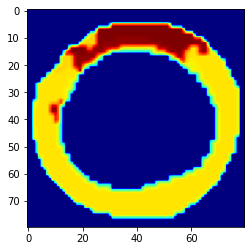

In [ ]:
seg_scar_ex_transformed = visualize_transforms(filename_seg_scar_ex)
plt.imshow(seg_scar_ex_transformed[0,:,:,35], cmap="jet")

# **Define GradCAM**

In [ ]:
from monai.visualize.visualizer import default_upsampler


In [ ]:
def default_normalizer(x) -> np.ndarray:
    """
    A linear intensity scaling by mapping the (min, max) to (1, 0).

    N.B.: This will flip magnitudes (i.e., smallest will become biggest and vice versa).
    """
    if isinstance(x, torch.Tensor):
        x = x.detach().cpu().numpy()
    scaler = ScaleIntensity(minv=0.0, maxv=1.0)
    x = [scaler(x) for x in x]
    return np.stack(x, axis=0)

In [ ]:
# gradcam.py

class PropBase(object):

    def __init__(self, model, target_layer, cuda=True):
        self.model = model
        self.cuda = cuda
        if self.cuda:
            self.model.cuda()
        self.model.eval()
        self.target_layer = target_layer
        self.outputs_backward = OrderedDict()
        self.outputs_forward = OrderedDict()
        self.set_hook_func()

    def set_hook_func(self):
        raise NotImplementedError

    # set the target class as one others as zero. use this vector for back prop
    # def encode_one_hot(self, idx):
    #     one_hot = torch.FloatTensor(1, self.n_class).zero_()
    #     one_hot[0][idx] = 1.0
    #     return one_hot

    # set the target class as one others as zero. use this vector for back prop added by Lezi
    def encode_one_hot_batch(self, z, mu, logvar, mu_avg, logvar_avg):# icetin: why this returns mu??????
        one_hot_batch = torch.FloatTensor(z.size()).zero_() # all zeros
       
        return mu # icetin: when this returns one_hot_batch score_fc =0 otherwise different score values for each case...
        # [maybe] return one_hotbatch when you train with normal and test with abnormal ==> abnormality detection : NO: results are all black
        # return mu o.w.

    def forward(self, x): # icetin: run the VAE and return the outputs
        #self.preds = self.model(x) # icetin: ? No need
        self.image_size = x.size(-1) 
        
        recon_batch, self.mu, self.logvar, self.out_mlp = self.model(x) 
        return recon_batch, self.mu, self.logvar, self.out_mlp

    # icetin: back prop the one_hot signal
    def backward(self, mu, logvar, mu_avg, logvar_avg):
        self.model.zero_grad()
        z = self.model.reparameterize_eval(mu, logvar).cuda() # use the mu and logvar from forward pass and sample z ( then what is the z's dim???)
        print(f" dimension of the latent sample: {z.size()}") # [1, 64]
        one_hot = self.encode_one_hot_batch(z, mu, logvar, mu_avg, logvar_avg)# this returns mu

        if self.cuda:
            one_hot = one_hot.cuda()
        #flag = 2 # icetin: why??? -- never goes into first condition (flag==1) but in the paper--> attention maps are calculated using relu???
        flag=1
        if flag == 1:
            self.score_fc = torch.sum(F.relu(one_hot * mu))
            print(f" flag==1 and score_fc is : {self.score_fc}") #icetin: check the calculated score
        else:
            self.score_fc = torch.sum(one_hot)
            print(f" flag !=1 and score_fc is : {self.score_fc}")
        self.score_fc.backward(retain_graph=True)

    def get_conv_outputs(self, outputs, target_layer): # icetin: this function outputs the selected conv layer's output : Feature maps
        for key, value in outputs.items():
            for module in self.model.named_modules():
                if id(module[1]) == key:
                    if module[0] == target_layer:
                        
                        return value
        raise ValueError('invalid layer name: {}'.format(target_layer))

class GradCAM(PropBase):

    def set_hook_func(self):
        def func_b(module, grad_in, grad_out):
            self.outputs_backward[id(module)] = grad_out[0].cpu()

        def func_f(module, input, f_output):
            self.outputs_forward[id(module)] = f_output

        for module in self.model.named_modules():
            module[1].register_backward_hook(func_b)
            module[1].register_forward_hook(func_f)

    def normalize(self, grads):
        l2_norm = torch.sqrt(torch.mean(torch.pow(grads, 2))) + 1e-5
        return grads / l2_norm.item()

    def compute_gradient_weights(self):
        self.grads = self.normalize(self.grads) #icetin:  grads.size() = [1,2,5,5,5] [batch_size, selected_layers_output_channel, 5,5,5]
        print(f" grads inside compute_gradient_weights: {self.grads.size()}")
        self.map_size = self.grads.size()[2:] # map_size = [1,2, 5,5,5]
        #self.map_size = self.grads.size()[1:]
        print(f" map_size inside compute_gradient_weights: {self.map_size}")
        self.weights = nn.AvgPool3d(self.map_size)(self.grads) # 
        print(f" size of weights (compute_gradient_weights) after AvgPool3d {self.weights.size()}")
        #self.weights = nn.AvgPool3d(self.map_size[2])(self.grads)

    def generate(self):
        # get gradient
        self.grads = self.get_conv_outputs(
            self.outputs_backward, self.target_layer)
        # compute weithts based on the gradient
        self.compute_gradient_weights()

        # get activation
        self.activation = self.get_conv_outputs(
            self.outputs_forward, self.target_layer)

        self.weights.volatile = False
        print(f"SIZE OF ACTIVATION  : {self.activation.size()}")
        #self.activation = self.activation[:, :, :, :] # icetin: activation = [1,2,5,5,5] - first one is the batch_size, second one is the # of feature maps in the selected layer
        #self.activation = self.activation[None, :,:,:,:,:] #icetin: [1,1,2,5,5,5 ] #  this does not work 

        #self.weights = self.weights[:, :, :, :] #icetin: weights = [2,1,1,1]
        #self.weights = self.weights[:, None, :,:,:,:] icetin: not working
        print(f"SIZE OF WEIGHTS : {self.weights.size()}")
        #torch.nn.functional.conv3d(input, weight, bias=None, stride=1, padding=0, dilation=1, groups=1) → Tensor
        #icetin:
        #gcam = F.conv3d(self.activation, weight = (self.weights.cuda().unsqueeze(0)), stride=1, padding=0, groups=len(self.weights))
        print(f" groups = len weights : {len(self.weights)}")
        #icetin: no need # self.weights = self.weights.squeeze(dim=0)
        gcam = F.conv3d(self.activation, weight = (self.weights.cuda()), stride=1, padding=0, groups=len(self.weights)) # groups = # feature maps?
        print(f"gcam size after F.conv3d before squeeze: {gcam.size()}")
        #icetin: gcam = gcam.squeeze(dim=0)
        
        gcam = F.upsample(gcam, (self.image_size, self.image_size, self.image_size), mode="trilinear") #icetin: Upsample the attention map to the size of the image
        print(f"gcam size after upsample {gcam.size()}")
        gcam = torch.abs(gcam)

        return gcam



# **Define the model (VAE)**

In [ ]:
# model.py

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

#class Unflatten(nn.Module): 
#      def __init__(self, channel, height, width, depth):
#        super(Unflatten, self).__init__()
#        self.channel = channel
#        self.height = height
#        self.width = width
#        self.depth = depth
#      def forward(self, input):
#        return input.view(input.size(0), self.channel, self.height, self.width, self.depth)

class Unflatten(nn.Module):
     def forward(self, input, size= unflatten_channel):
        return input.view(input.size(0), size, dim_start_up_decoder[0], dim_start_up_decoder[1], dim_start_up_decoder[2])

class ConvVAE(nn.Module):

    def __init__(self, image_channels=IMG, h_dim=HDIM, latent_size = latent_size):
        super(ConvVAE, self).__init__()

        #icetin:   Liu et al 2D MNIST convolutional layers - 
        #self.latent_size = latent_size #z_dim  = Their latent size is 
        #self.encoder = nn.Sequential( ### LIU ET. AL ################################ 
        #    nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
        #    nn.ReLU(),
        #    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
        #    nn.ReLU(),
        #    Flatten(),
        #    nn.Linear(6272, 1024),
        #    nn.ReLU()
        #)

    ##############
    ## ENCODER ##
    ##############
     # icetin: this part is Conv3d version - check : biffi et. al. LVAE + MLP
        self.conv1_enc = nn.Conv3d(in_channels = IMG, out_channels = n_filters_ENC[0],  kernel_size = [3,3,3] , stride = 2, padding =1 )
        self.bn1_enc = nn.BatchNorm3d( n_filters_ENC[0])
        self.conv2_enc = nn.Conv3d(in_channels = n_filters_ENC[0], out_channels = n_filters_ENC[1], kernel_size = [3,3,3] , stride = 2, padding =1)
        self.bn2_enc = nn.BatchNorm3d( n_filters_ENC[1])
        self.conv3_enc = nn.Conv3d(in_channels = n_filters_ENC[1], out_channels = n_filters_ENC[2],  kernel_size = [3,3,3] , stride = 2, padding =1)
        self.bn3_enc = nn.BatchNorm3d( n_filters_ENC[2])
        self.conv4_enc = nn.Conv3d(in_channels = n_filters_ENC[2], out_channels = n_filters_ENC[3],  kernel_size = [3,3,3] , stride = 2, padding =1)
        self.bn4_enc = nn.BatchNorm3d( n_filters_ENC[3])
        self.conv5_enc = nn.Conv3d(in_channels = n_filters_ENC[3], out_channels = n_filters_ENC[4], kernel_size = [3,3,3], stride = 1 , padding =1)
        self.bn5_enc = nn.BatchNorm3d( n_filters_ENC[4])
        
        #self.maxpool = nn.MaxPool3d(kernel_size=[3,3,3], return_indices=True) #icetin: pooling layers return indices, No need for now

        self.flatten = Flatten() #icetin: flattens dims into tensor # shape : [2, 432]
       
             
        self.fc1 = nn.Linear(250, 128)     

        self.fc2 = nn.Linear(128, h_dim)
              
        

        # icetin: hidden => mu
        self.mu = nn.Linear(h_dim, latent_size)# icetin: input channels were changed from 1024(in Liu et. al, expVAE original implementation) to 64 = h_dim

        # icetin: hidden => logvar
        self.logvar = nn.Linear(h_dim, latent_size)# icetin: same above

        # icetin: MLP
        self.mlp = nn.Linear(latent_size, num_class) # icetin: apply MLP onto z 
    ###################
    ### END OF ENCODER
    ###################
       # icetin: Liu et. al decoder - 2D conv. ##############
       # self.decoder = nn.Sequential( ### LIU ET. AL ################################ 
       #     nn.Linear(self.latent_size, 1024),
       #     nn.ReLU(),
       #     nn.Linear(1024, 6272),
       #     nn.ReLU(),
       #     Unflatten(128, 7, 7),
       #     nn.ReLU(),
       #     nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
       #     nn.ReLU(),
       #     nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
       #     nn.Sigmoid()
       # )       

    ###############
    ### DECODER 
    ###############
        #icetin: biffi et. al decoder, LVAE + MLP
        self.fc3 = nn.Linear(latent_size, 250) #icetin: pulls from bottleneck to hidden # dim_start_up_decoder = [5,5,5]
        self.unflatten = Unflatten()
        #self.maxunpool = nn.MaxUnpool3d(kernel_size=2)  #icetin:  unpooling layers require indices from pooling layers, No need
        
        
        self.conv1_dec = nn.Conv3d(in_channels = unflatten_channel, out_channels = n_filters_DEC[0],  kernel_size = [3,3,3], stride = 1, padding =1)
        self.bn1_dec = nn.BatchNorm3d(n_filters_DEC[0])
        self.deconv1_dec = nn.ConvTranspose3d(in_channels =  n_filters_DEC[0], out_channels =  n_filters_DEC[0], kernel_size = [3,3,3], stride = 2, padding =1, output_padding=1)
        self.bn2_dec = nn.BatchNorm3d(n_filters_DEC[0])
        self.deconv2_dec = nn.ConvTranspose3d(in_channels =  n_filters_DEC[0], out_channels =  n_filters_DEC[1], kernel_size = [3,3,3], stride = 2, padding =1, output_padding=1)
        self.bn3_dec = nn.BatchNorm3d(n_filters_DEC[1])
        self.deconv3_dec = nn.ConvTranspose3d(in_channels =  n_filters_DEC[1], out_channels =  n_filters_DEC[2], kernel_size = [3,3,3], stride = 2, padding =1, output_padding=1)
        self.bn4_dec = nn.BatchNorm3d(n_filters_DEC[2])
        self.deconv4_dec = nn.ConvTranspose3d(in_channels =  n_filters_DEC[2], out_channels =  n_filters_DEC[3], kernel_size = [3,3,3], stride = 2, padding =1, output_padding=1)
        self.bn5_dec = nn.BatchNorm3d(n_filters_DEC[3])
        self.conv2_dec = nn.Conv3d(in_channels = n_filters_DEC[3], out_channels = n_filters_DEC[4], kernel_size = [3,3,3], stride = 1, padding =1)
        self.bn6_dec = nn.BatchNorm3d(n_filters_DEC[4])
        self.conv3_dec = nn.Conv3d(in_channels = n_filters_DEC[4], out_channels = IMG, kernel_size = [3,3,3], stride = 1, padding =1)
        self.bn7_dec = nn.BatchNorm3d(IMG)
        

        self.sigmoid = nn.Sigmoid()
   ##################
   ### END OF DECODER
   ##################

    def encode(self, x): # icetin: encoder returns mu and logvar
        
        h = F.relu(self.bn1_enc(self.conv1_enc(x)))
        h = F.relu(self.bn2_enc(self.conv2_enc(h)))
        h = F.relu(self.bn3_enc(self.conv3_enc(h)))
        h = F.relu(self.bn4_enc(self.conv4_enc(h)))
        h = F.relu(self.bn5_enc(self.conv5_enc(h)))

        h = self.flatten(h)
        
        h = F.relu(self.fc1(h))
        h = F.relu(self.fc2(h))

        mu, logvar = self.mu(h), self.logvar(h)
        
        return mu, logvar

    def decode(self, z): #icetin: input of the decoder is z and returns reconstructed image.
        z = F.relu(self.fc3(z))
        z = self.unflatten(z)

        z = F.relu(self.bn1_dec(self.conv1_dec(z)))
        z = F.relu(self.bn2_dec(self.deconv1_dec(z)))
        z = F.relu(self.bn3_dec(self.deconv2_dec(z)))
        z = F.relu(self.bn4_dec(self.deconv3_dec(z)))
        z = F.relu(self.bn5_dec(self.deconv4_dec(z)))
        z = F.relu(self.bn6_dec(self.conv2_dec(z)))
        z = F.relu(self.bn7_dec(self.conv3_dec(z)))


        z = self.sigmoid(z)
        return z

    def mlp_predict(self, z): #icetin: mlp part that is connected to z, as in biffi et. al., LVAE + MLP
        out_mlp = self.mlp(z) # input: z output: prediction
        return out_mlp

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def reparameterize_eval(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def forward(self, x): # icetin: forward prop of the network.
        mu, logvar = self.encode(x) # encoder returns mu and sigma
        z = self.reparameterize(mu, logvar) # reparameterization trick returns sample, z
        out_mlp = self.mlp_predict(z) # mlp branch takes z and outputs the predictions
        return self.decode(z), mu, logvar, out_mlp # reconstructed x, mu, logvar, mlp output

In [ ]:
model = ConvVAE(image_channels=IMG, h_dim =HDIM, latent_size=latent_size)

In [ ]:
model.parameters

<bound method Module.parameters of ConvVAE(
  (conv1_enc): Conv3d(1, 8, kernel_size=[3, 3, 3], stride=(2, 2, 2), padding=(1, 1, 1))
  (bn1_enc): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_enc): Conv3d(8, 16, kernel_size=[3, 3, 3], stride=(2, 2, 2), padding=(1, 1, 1))
  (bn2_enc): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_enc): Conv3d(16, 32, kernel_size=[3, 3, 3], stride=(2, 2, 2), padding=(1, 1, 1))
  (bn3_enc): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4_enc): Conv3d(32, 64, kernel_size=[3, 3, 3], stride=(2, 2, 2), padding=(1, 1, 1))
  (bn4_enc): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5_enc): Conv3d(64, 2, kernel_size=[3, 3, 3], stride=(1, 1, 1), padding=(1, 1, 1))
  (bn5_enc): BatchNorm3d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (flatten): Flatten()
  (fc1): Linear(in_featu

# **Loss Function**

In [ ]:
# train_expVAE.py

cuda = torch.cuda.is_available()
if cuda:
    print('cuda available')

device = torch.device("cuda" if cuda else "cpu")


def loss_function(recon_x, x, mu, logvar):
    # reconstruction loss
    BCE = F.binary_cross_entropy(recon_x.view(-1), x.view(-1), reduction='sum')
    #BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    
    # KL divergence loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD
def mlp_loss_function(y, out_mlp):
    # MLP loss, biffi uses (in tensorflow) tf.nn.softmax_cross_entropy_with_logits
    # there is no pytorch func. but the equivalent implementation of the function...
    loss = torch.sum(- y * F.log_softmax(out_mlp, -1), -1)
    mean_loss = loss.mean()
    return mean_loss

cuda available


# **Train the model**

In [ ]:
### Training #####
#MAGB def train(epoch, model, train_loader, optimizer, args):
def train(epoch, model, train_loader, optimizer):
    model.train()
    train_loss = 0

    for batch_idx, (data, label) in enumerate(train_loader):
        data = data.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar, out_mlp = model(data)
        
        loss = loss_function(recon_batch, data, mu, logvar) + mlp_loss_function(label, out_mlp) # icetin: added mlp loss (biffi et. al)
        train_loss += loss.item() # icetin: makes the result scalar

        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader.dataset)

    return train_loss

### Validating ####
#MAGB def test(epoch, model, test_loader, args):
def test(epoch, model, test_loader):
    model.eval()
    test_loss = 0

    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(test_loader):
            data = data.to(device)
            label = label.to(device)
            recon_batch, mu, logvar, out_mlp = model(data)

            loss_ = loss_function(recon_batch, data, mu, logvar) + mlp_loss_function(label, out_mlp)
            test_loss += loss_.item()

    test_loss /= len(test_loader.dataset)

    return test_loss


def save_checkpoint(state, is_best, outdir):
    if not os.path.exists(outdir):
        os.makedirs(outdir)
    checkpoint_file = os.path.join(outdir, 'checkpoint.pth')
    best_file = os.path.join(outdir, 'model_best.pth')
    torch.save(state, checkpoint_file)
    if is_best:
        shutil.copyfile(checkpoint_file, best_file)



Start Training

In [ ]:
def main_train(HDIM, IMG, latent_size, epoch):
 result_dir = 'train_results'
 ckpt_dir = 'ckpt'
 # batch_size = 128
 
 seed = 1
 resume = False
 #one_class = 3
 torch.manual_seed(seed)

 kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
 model = ConvVAE(image_channels=IMG, h_dim=HDIM, latent_size= latent_size).to(device)
 optimizer = optim.Adam(model.parameters(), lr=1e-3)

 start_epoch = 0
 best_test_loss = np.finfo('f').max

 if resume:
   if os.path.isfile(resume):

            print('=> loading checkpoint %s' % resume)
            checkpoint = torch.load(resume)
            start_epoch = checkpoint['epoch'] + 1
            best_test_loss = checkpoint['best_test_loss']
            model.load_state_dict(checkpoint['state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer'])
            print('=> loaded checkpoint %s' % resume)
   else:
            print('=> no checkpoint found at %s' % resume)

 for epoch in range(start_epoch, epochs):

        train_loss = train(epoch, model, train_loader, optimizer)
        test_loss = test(epoch, model, val_loader) 
        

        print('Epoch [%d/%d] loss: %.3f val_loss: %.3f' % (epoch + 1, epochs, train_loss, test_loss))

        is_best = test_loss < best_test_loss
        best_test_loss = min(test_loss, best_test_loss)
        save_checkpoint({
            'epoch': epoch,
            'best_test_loss': best_test_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }, is_best, os.path.join('./',ckpt_dir))

        # Visualize sample validation result
        with torch.no_grad():
            sample = torch.randn(1, 64).to(device)
            sample = model.decode(sample).cpu()
            img = make_grid(sample)

            #save_dir = os.path.join('./',result_dir)
            #if not os.path.exists(save_dir):
            #    os.makedirs(save_dir)
            #save_image(sample.view(1, 2, 80, 80, 80), os.path.join(save_dir,'sample_' + str(epoch) + '.nii.gz'))



In [ ]:
main_train(HDIM, IMG, latent_size, epochs)

Epoch [1/200] loss: -353631911.403 val_loss: -738251267.879
Epoch [2/200] loss: -497466175.045 val_loss: -607920463.515
Epoch [3/200] loss: -558584256.000 val_loss: -593247833.212
Epoch [4/200] loss: -617988617.075 val_loss: -805163673.212
Epoch [5/200] loss: -683165743.284 val_loss: -764709632.000
Epoch [6/200] loss: -743019288.836 val_loss: -761545925.818
Epoch [7/200] loss: -802037696.000 val_loss: -775968114.424
Epoch [8/200] loss: -852742004.537 val_loss: -878663546.182
Epoch [9/200] loss: -910537579.940 val_loss: -966158743.273
Epoch [10/200] loss: -964089276.179 val_loss: -1028799804.121
Epoch [11/200] loss: -1024154365.134 val_loss: -1015712036.848
Epoch [12/200] loss: -1085487272.119 val_loss: -1103555917.576
Epoch [13/200] loss: -1141604981.493 val_loss: -1173502910.061
Epoch [14/200] loss: -1198068916.537 val_loss: -1121077769.697
Epoch [15/200] loss: -1258226786.388 val_loss: -1278831782.788
Epoch [16/200] loss: -1318581197.373 val_loss: -1270132608.000
Epoch [17/200] loss:

# **Latent space visualization**

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
# load the best hyperparameters
vis_vae = ConvVAE().cuda()

vis_vae.load_state_dict(torch.load("ckpt/model_best.pth"), strict=False)

_IncompatibleKeys(missing_keys=['conv1_enc.weight', 'conv1_enc.bias', 'bn1_enc.weight', 'bn1_enc.bias', 'bn1_enc.running_mean', 'bn1_enc.running_var', 'conv2_enc.weight', 'conv2_enc.bias', 'bn2_enc.weight', 'bn2_enc.bias', 'bn2_enc.running_mean', 'bn2_enc.running_var', 'conv3_enc.weight', 'conv3_enc.bias', 'bn3_enc.weight', 'bn3_enc.bias', 'bn3_enc.running_mean', 'bn3_enc.running_var', 'conv4_enc.weight', 'conv4_enc.bias', 'bn4_enc.weight', 'bn4_enc.bias', 'bn4_enc.running_mean', 'bn4_enc.running_var', 'conv5_enc.weight', 'conv5_enc.bias', 'bn5_enc.weight', 'bn5_enc.bias', 'bn5_enc.running_mean', 'bn5_enc.running_var', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'mu.weight', 'mu.bias', 'logvar.weight', 'logvar.bias', 'mlp.weight', 'mlp.bias', 'fc3.weight', 'fc3.bias', 'conv1_dec.weight', 'conv1_dec.bias', 'bn1_dec.weight', 'bn1_dec.bias', 'bn1_dec.running_mean', 'bn1_dec.running_var', 'deconv1_dec.weight', 'deconv1_dec.bias', 'bn2_dec.weight', 'bn2_dec.bias', 'bn2_dec.running_m

In [ ]:
batch_x =batch_size
latent_z = []
targets = []
for batch_x in train_loader:
  data = batch_x[0]

  data = data.cuda().float() 
  mu, logvar = vis_vae.encode(data)
  z = vis_vae.reparameterize(mu, logvar).detach().cpu().numpy()
  #print(z.shape)
  latent_z.append(z)
  targets.append(batch_x[1].detach().cpu().numpy())

In [ ]:
latent_z = np.asanyarray(latent_z).reshape(len(latent_z),latent_size)

Text(0.5, 1.0, 'Latent space vis. with T-SNE')

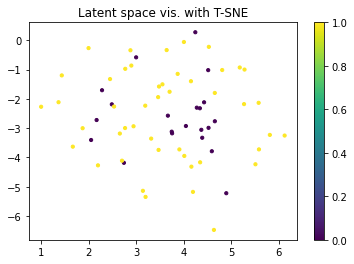

In [ ]:
model_tsne = TSNE(n_components=2, n_iter=12000, random_state=False) # show the latent space in 2 dimension
#z_states = latent_z.detach().cpu().numpy() # from tensor: gpu to cpu:numpy
z_embed = model_tsne.fit_transform(latent_z)
classes = np.asanyarray(targets)

fig = plt.figure
plt.scatter(z_embed[:, 0], z_embed[:,1], c=classes, s=10)
plt.colorbar()
plt.title("Latent space vis. with T-SNE") 
#fig.savefig('./vae_results/'+str(name)+'_embedding_'+str(ic)+'.png')
#fig.savefig('./vae_results/'+str(name)+'_embedding.png')
# Note: 1=MINF and 0:Healthy

# **Test the model**

 **CONFIGURATIONS**

In [ ]:
target_layer = "conv1_enc" # target layer to be visualized

In [ ]:
 # Variables to binarize the attention maps
 low_t = 0.65 #lower threshold to binarize and save the attention map
 up_t = 1 ## upper threshold

In [ ]:
# Visualizations/plots will be saved here : PNG
save_plot = "/content/gdrive/MyDrive/Colab Notebooks/Results_EMIDEC/SYN_myo_only_mlp/Plots/" 
# images and their corresponding attention maps will be saved here : NIFTI
result_path ="/content/gdrive/MyDrive/Colab Notebooks/Results_EMIDEC/SYN_myo_only_mlp/CONV"+target_layer[4] +"/"

In [ ]:
if os.path.isdir(result_path):
     pass
else:
    os.makedirs(result_path)
if os.path.isdir(save_plot):
     pass
else:
    os.makedirs(save_plot)

In [ ]:
result_dir = 'test_results'
model_path = './ckpt/model_best.pth'
torch.manual_seed(seed)
mu_avg, logvar_avg = 0, 1


model = ConvVAE(image_channels=IMG, h_dim =HDIM, latent_size=latent_size)
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['state_dict'])
gcam = GradCAM(model, target_layer=target_layer, cuda=True) 
    

In [ ]:
path_example_img = "/content/gdrive/MyDrive/EMIDEC/Emidec_DATASET/Training/Case_N006/Images/Case_N006.nii.gz"
img_example = nib.load(path_example_img)

image saved!
Attention map is being generated...
out_mlp: [[1.598491  1.2084405]]
 dimension of the latent sample: torch.Size([1, 64])
 flag==1 and score_fc is : 1051.93798828125
 grads inside compute_gradient_weights: torch.Size([1, 8, 40, 40, 40])
 map_size inside compute_gradient_weights: torch.Size([40, 40, 40])
 size of weights (compute_gradient_weights) after AvgPool3d torch.Size([1, 8, 1, 1, 1])
SIZE OF ACTIVATION  : torch.Size([1, 8, 40, 40, 40])
SIZE OF WEIGHTS : torch.Size([1, 8, 1, 1, 1])
 groups = len weights : 1
gcam size after F.conv3d before squeeze: torch.Size([1, 1, 40, 40, 40])
gcam size after upsample torch.Size([1, 1, 80, 80, 80])
Done!


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:785: UserWarning: Using a non-full backward hook when outputs are generated by different autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_output. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when outputs are generated by different autograd Nodes "
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:106: UserWarning: volatile was removed and now has no effect. 

Results are saved!
image saved!
Attention map is being generated...
out_mlp: [[-5.1066394 -5.27484  ]]
 dimension of the latent sample: torch.Size([1, 64])
 flag==1 and score_fc is : 6583.3876953125
 grads inside compute_gradient_weights: torch.Size([1, 8, 40, 40, 40])
 map_size inside compute_gradient_weights: torch.Size([40, 40, 40])
 size of weights (compute_gradient_weights) after AvgPool3d torch.Size([1, 8, 1, 1, 1])
SIZE OF ACTIVATION  : torch.Size([1, 8, 40, 40, 40])
SIZE OF WEIGHTS : torch.Size([1, 8, 1, 1, 1])
 groups = len weights : 1
gcam size after F.conv3d before squeeze: torch.Size([1, 1, 40, 40, 40])
gcam size after upsample torch.Size([1, 1, 80, 80, 80])
Done!
Results are saved!
image saved!
Attention map is being generated...
out_mlp: [[6.882143  7.2057586]]
 dimension of the latent sample: torch.Size([1, 64])
 flag==1 and score_fc is : 6862.8330078125
 grads inside compute_gradient_weights: torch.Size([1, 8, 40, 40, 40])
 map_size inside compute_gradient_weights: torc

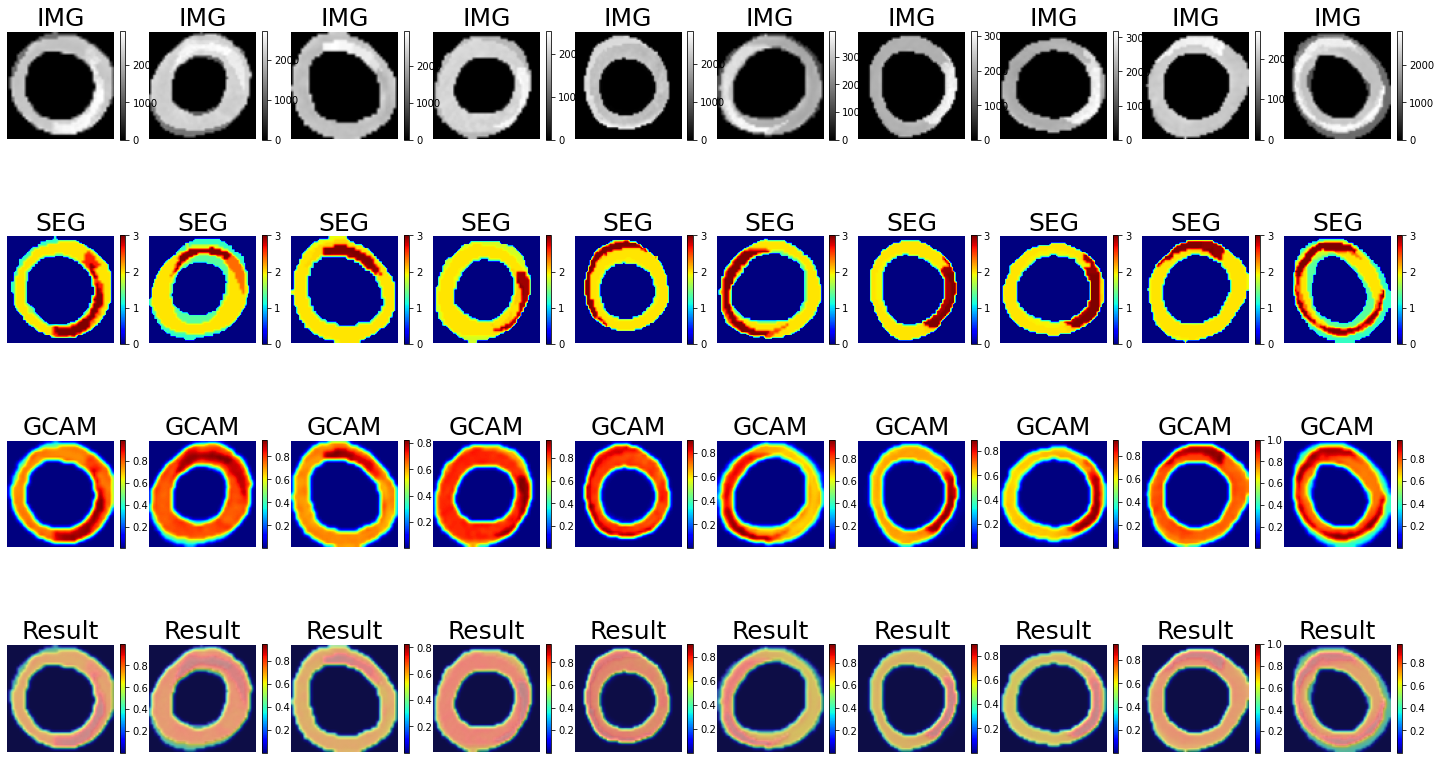

In [ ]:
# Visualize Results and Gradcam images
n_examples = len(test_ds)
visualize_ex = 10
subplot_shape = [4, visualize_ex]
fig, axes = plt.subplots(*subplot_shape, figsize=(25,15), facecolor='white')
plt.subplots_adjust(hspace=0.01)
items = range(0, len(test_ds)) #*
#items = [25, 30]
example = 0
vis_ex = 0
#for batch_idx, (x, _) in enumerate(test_loader):
for item in items:
        data = test_ds[item]
        x, label = data[0].to(device).unsqueeze(0), data[1]              
        filename =  test_ds.image_files[item]
        the_slice = x.shape[-1] // 2 +5
        img = x.detach().cpu().numpy() # use this to save
        #######################################
        ## Save the image #####################################################
        #
        toSave_img = nib.Nifti1Image(img.reshape(
                        [win_size[0], win_size[1], win_size[2], 1]),
                        img_example.affine)
        nib.save(toSave_img, result_path + filename[97:106]+'_img.nii.gz')
        print("image saved!")
        #######################################################################


        
        img_ = img[..., the_slice]
        ### ATTENTION GENERATION ###############################################        
        model.eval()
        print("Attention map is being generated...")      
        x_rec, mu, logvar, out_mlp = gcam.forward(x)
        prediction = out_mlp.detach().cpu().numpy()
        print(f"out_mlp: {prediction}")
        model.zero_grad()
        gcam.backward(mu, logvar, mu_avg, logvar_avg)
        gcam_map = gcam.generate() 
        print("Done!")
        #### DONE!!! ###########################################################

        gcam_map = default_normalizer(gcam_map.detach().cpu().data.numpy())       

        ## Save the attention map as NIFTI #####################################
        ## Threshold 0 = min, 1 = max
        itk_gcam_map = sitk.GetImageFromArray(gcam_map[0,0,:,:,:])
        name_gcam = filename[97:106] + "_GCAM"

        gcam_mask = mask_operations(itk_gcam_map, name_gcam, result_path, low_t, up_t, Train=False) 
        print("Results are saved!")
        ########################################################################     
        gcam_map_slc = gcam_map[..., the_slice]       
        cam_and_img, gcam_map_, image_to_vis= superimposed_image_def(gcam_map_slc, img_)
        #img_ = img_[0,0,:,:]

        
        # Scar segmentation of the crresponding image
        seg_scar = filename[:-7]
        filename_seg_scar = seg_scar + "_gt_scar"+ ".nii.gz"
        seg_scar_transformed = visualize_transforms(filename_seg_scar)
        scar_img = seg_scar_transformed.detach().cpu().unsqueeze(0)[...,the_slice]
        
        toSave_GT = nib.Nifti1Image(seg_scar_transformed.detach().cpu().numpy().reshape(
                        [win_size[0], win_size[1], win_size[2], 1]),
                        img_example.affine)
        nib.save(toSave_GT, result_path + filename[97:106]+'_SCAR_GT.nii.gz')

        scar_img = scar_img[0,:,:]
       
        #cam_and_img = save_cam(gcam_map_, img_ED)
        ## Visualize and save attention maps  ##

        ### Visualize the attention maps and the images ########################
        if vis_ex < visualize_ex and label ==0: ### To visualize MINF cases

            for row, (im, title) in enumerate(zip(
                [img_[0][0], scar_img, gcam_map[0,0,:,:,the_slice], cam_and_img],
                ["IMG", "SEG", "GCAM", "Result"],
            )):
                #cmap = 'gray' if row == 0  else 'jet'
                ax = axes[row, vis_ex]
                if isinstance(im, torch.Tensor):
                    im = im.cpu().detach()
                if row==0:
                    im_show = ax.imshow(im, cmap="gray")
                elif row==2 :
                    im_show = ax.imshow(im, cmap="jet")
                elif row==1: 
                    im_show = ax.imshow(im[0], cmap="jet")
                elif row ==3:
                    ax.imshow( gcam_map[0,0,:,:,the_slice], alpha= 0.9, cmap="jet")
                    ax.imshow( img_[0][0],alpha=0.5, cmap="gray")
                else :
                    im_show = ax.imshow(np.squeeze(im))

                ax.set_title(title, fontsize=25)
                ax.axis('off')           
                fig.colorbar(im_show, fraction=0.046, ax=ax)

            vis_ex += 1
            name_plt = save_plot + "EMIDEC" + "_" + target_layer 
            plt.savefig( name_plt +".png", dpi=300, bbox_inches='tight')

        if example == n_examples:
           break


        if example == n_examples:
          break


In [ ]:
x = x.repeat(1, 3, 1, 1,1)

In [ ]:
x.size(0)

1

In [ ]:
x.shape

torch.Size([1, 3, 80, 80, 80])